In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import mplcyberpunk
import tensorflow as tf

2024-09-19 17:11:02.778223: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 17:11:02.781309: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-19 17:11:02.791998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 17:11:02.809088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 17:11:02.813820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 17:11:02.826817: I tensorflow/core/platform/cpu_feature_gu

In [2]:
tickers = ['PETR4.SA']
petr4 = yf.download(tickers, start = '2013-01-02', end = '2021-12-30')

petr4

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.990000,20.209999,19.690001,19.690001,5.815256,30182600
2013-01-03,19.809999,20.400000,19.700001,20.400000,6.024948,30552600
2013-01-04,20.330000,20.620001,20.170000,20.430000,6.033809,36141000
2013-01-07,20.480000,20.670000,19.950001,20.080000,5.930440,28069600
2013-01-08,20.110001,20.230000,19.459999,19.500000,5.759141,29091300
...,...,...,...,...,...,...
2021-12-22,28.400000,28.400000,27.969999,28.160000,11.986899,33734500
2021-12-23,28.330000,28.420000,28.150000,28.330000,12.059263,28713600
2021-12-27,28.320000,28.780001,28.150000,28.750000,12.238048,44227900


In [3]:
petr4 = petr4.reset_index()

petr4['Date'] = pd.to_datetime(petr4['Date'], format = '%Y-%m-%d')

In [4]:
precos = petr4['Close']

# O RNN observa toda a série temporal, entretanto ele é particularmente
# sensível a um intervalo próoximo, o qual iremos definir na próxima linha
sensibilidade = 15

# Definindo o quanto da nossa base de dados será utilizada para treinamento
treino_size = int(len(precos) * 0.95)

# Definindo o quanto da nossa base de dados será utilizada para teste
teste_size = len(precos) - treino_size

# Definindo os dados de treinamento e, ao que eu entendi até o momento, os
# dados com maior sensibilidade, armazenados em teste_data
treino_data, teste_data = np.array(precos[:treino_size]), np.array(precos[treino_size - sensibilidade:])

# Dados de validação, ao que eu entendi serão usados para comparar com os
# valores encontrandos pela rede neural
val_data = np.array(precos[treino_size:])

treino_data.shape[0], teste_data.shape[0]

(2121, 127)

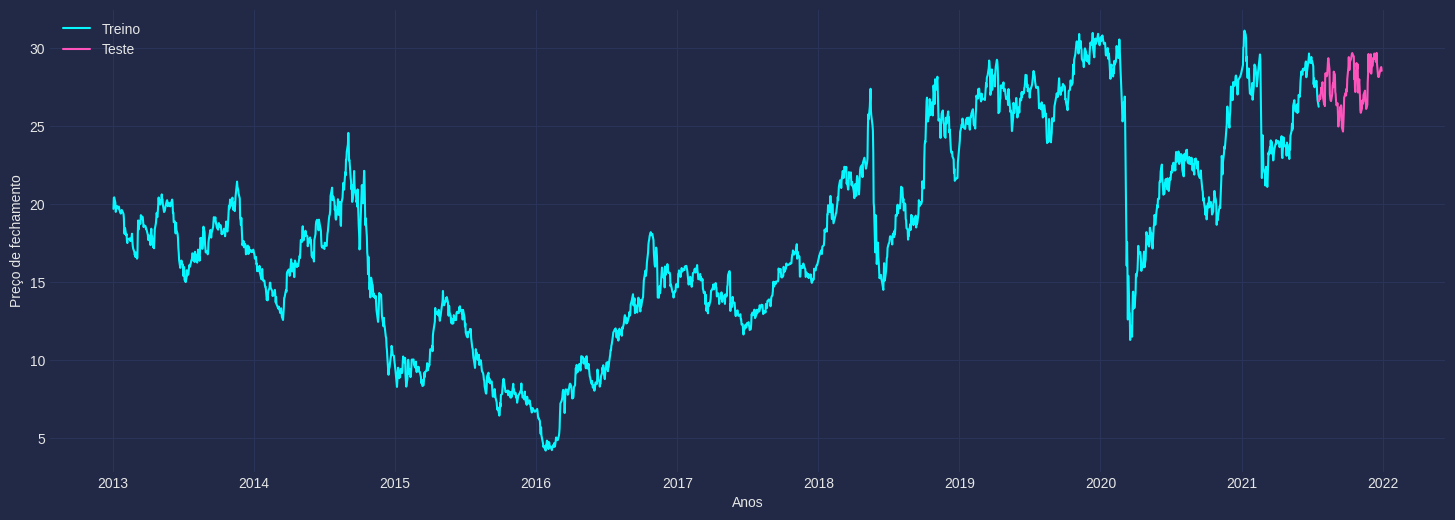

In [5]:
plt.rcParams['figure.figsize'] = [18, 6]
plt.style.use('cyberpunk')

plt.plot(petr4['Date'][:treino_size], petr4['Close'][:treino_size], label = 'Treino')
plt.plot(petr4['Date'][treino_size:], petr4['Close'][treino_size:], label = 'Teste')
plt.xlabel('Anos')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))

treino_data_normalizado = scaler.fit_transform(np.array(treino_data).reshape(-1, 1))
teste_data_normalizado = scaler.transform(np.array(teste_data).reshape(-1, 1))
val_data_normalizado = scaler.transform(np.array(val_data).reshape(-1, 1))

treino_data_normalizado.shape

#Notas: observe que há uma sutileza no processo de normalização dos dados, de
# forma que, enquanto utilizamos o fit_transform para os dados de treinamento,
#usamos apenas transform para os demais. Segundo o tutorial, se aplicarmos
# o fit_transform ao teste, estamos ajudando o algoritmo, tornando os
# resultados inviesados pra aquilo que já deveria ser, como se estivéssimos
# dando cola pra ele. Não ficou tão claro pra mim a forma como isso acontece,
#se eu descobrir(e lembrar), eu volto aqui com a explicação.

(2121, 1)

In [19]:
x_train, y_train = [], []

for i in range(sensibilidade, len(treino_data)):
    x_train.append(treino_data_normalizado[i - sensibilidade:i])
    y_train.append(treino_data_normalizado[i])


x_teste = []
for i in range(sensibilidade, len(teste_data)):
    x_teste.append(teste_data_normalizado[i - sensibilidade:i])

x_val, y_val = [], []
for i in range(sensibilidade, len(val_data_normalizado)):
    x_val.append(val_data_normalizado[i - sensibilidade:i])
    y_val.append(val_data_normalizado[i])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_teste = np.array(x_teste)
x_val = np.array(x_val)
y_val = np.array(y_val)

x_teste.shape

    

(112, 15, 1)

In [20]:
tf.__version__

'2.17.0'

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN


model = Sequential()
model.add(SimpleRNN(100, return_sequences = False, input_shape = (sensibilidade, 1)))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer = 'adam')

model.summary()

/home/petee/kaio_personal/python_applications/rnntutorial/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
h = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 30, batch_size = 32)


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0534 - val_loss: 0.0024
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8570e-04 - val_loss: 0.0012
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2284e-04 - val_loss: 0.0014
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9877e-04 - val_loss: 0.0010
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7449e-04 - val_loss: 0.0011
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.2838e-04 - val_loss: 0.0010
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0734e-04 - val_loss: 9.2211e-04
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 9.9025e-04
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8718e-04 - val_loss: 0.0013
Epoch 11/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3788e-04 - val_loss: 0.0015
Epoch 12/30
66/66 ━━━━━━━━━━━━━━━━

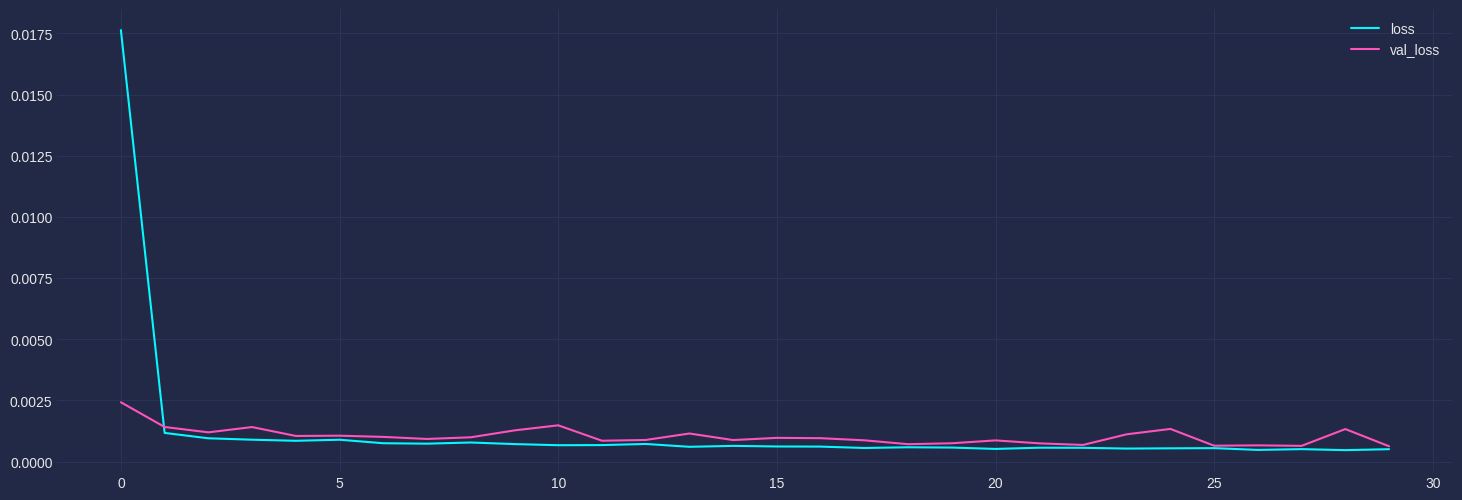

In [24]:
plt.plot(h.history['loss'], label = 'loss')
plt.plot(h.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [25]:
predict = model.predict(x_teste)
predict = scaler.inverse_transform(predict)
real = teste_data

predict.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


(112, 1)

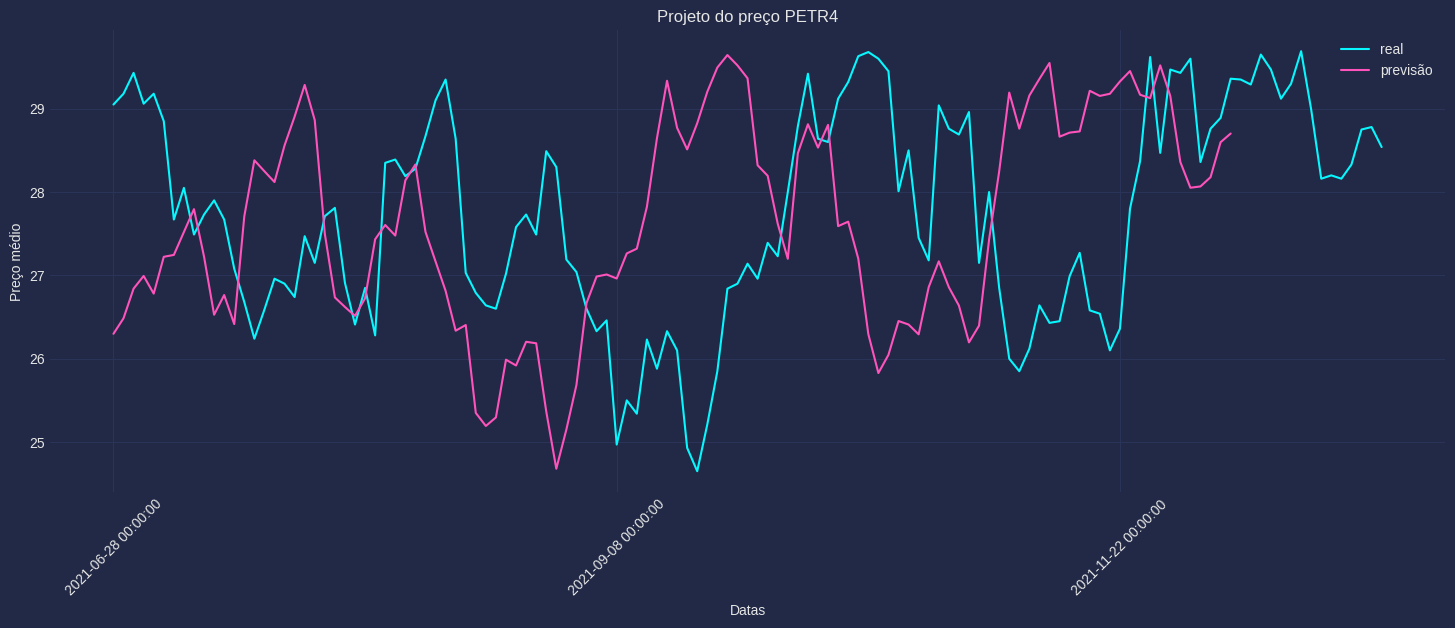

In [26]:
plt.plot(real, label = 'real')
plt.plot(predict, label = 'previsão')
plt.xticks(range(0, len(real), 50), petr4['Date'].iloc[- len(real)::50], rotation = 45)
plt.xlabel('Datas')
plt.ylabel('Preço médio')
plt.title('Projeto do preço PETR4')
plt.legend()
plt.show()